In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

import numpy as np
import tensorflow as tf
import pathlib 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import BinaryAccuracy
import sys, os,io,re, csv, codecs


#spacy.load('en_core_web_sm')
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Nous cahrgeons les fichiers: 
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')
sample_submission = pd.read_csv('/content/sample_submission.csv')

In [ ]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df_train.shape

(7613, 5)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
# on va supprimer la colonne id qui n'est pas nécessaire pour l'analyse 
df_train.drop(columns="id", axis = 1, inplace = True)
df_train.head()

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
#On vérifie s'il y a des doublons dans les enregistrements 
duplicates_record = df_train[df_train.duplicated(subset=['text'], keep=False)] #subset nous permet d'identifier la colonne dans laquelle on veut 
# chercher les doublons, keep = false il va nous afficher les doublons en true 
duplicates_record

,keyword,location,text,target
606,bioterrorism,NaN,To fight bioterrorism sir.,1
620,bioterrorism,NaN,To fight bioterrorism sir.,0
1190,buildings%20burning,"Mackay, QLD, Australia",Mmmmmm I'm burning.... I'm burning buildings I...,1
1207,buildings%20burning,"Epic City, BB.",I Pledge Allegiance To The P.O.P.E. And The Bu...,0
1214,buildings%20burning,dallas,like for the music video I want some real acti...,1
1323,burning%20buildings,"Mackay, QLD, Australia",Mmmmmm I'm burning.... I'm burning buildings I...,0
1337,burning%20buildings,dallas,like for the music video I want some real acti...,0
1351,burning%20buildings,"Epic City, BB.",I Pledge Allegiance To The P.O.P.E. And The Bu...,1
2802,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,1
2803,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,0


In [ ]:
#Environ 179 enregistrements en double sont trouvés. Considérons maintenant (Texte, cible) et ne gardons que le premier
#enregistrement de l'enregistrement en double et supprimez le reste
df_train.drop_duplicates(subset = ['text','target'], keep = 'first', inplace = True, ignore_index = True)
duplicates_record = df_train[df_train.duplicated(subset=['text'], keep=False)]# on refait encore une fois duplicate pr voir s'il nous reste d'autres doublons 
duplicates_record

,keyword,location,text,target
606,bioterrorism,NaN,To fight bioterrorism sir.,1
620,bioterrorism,NaN,To fight bioterrorism sir.,0
1190,buildings%20burning,"Mackay, QLD, Australia",Mmmmmm I'm burning.... I'm burning buildings I...,1
1207,buildings%20burning,"Epic City, BB.",I Pledge Allegiance To The P.O.P.E. And The Bu...,0
1214,buildings%20burning,dallas,like for the music video I want some real acti...,1
1323,burning%20buildings,"Mackay, QLD, Australia",Mmmmmm I'm burning.... I'm burning buildings I...,0
1337,burning%20buildings,dallas,like for the music video I want some real acti...,0
1351,burning%20buildings,"Epic City, BB.",I Pledge Allegiance To The P.O.P.E. And The Bu...,1
2802,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,1
2803,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,0


In [ ]:
duplicates_record.shape

(36, 4)

In [ ]:
#Il existe encore  divers enregistrements en doublon disponibles, mais avec une différence, 
#cette fois pour le même tweet une cible temporelle est 0 et pour une autre elle est 1. Cela semble être des 
#enregistrements corrompus et le modèle NLP peut être confus, il est donc préférable de supprimer ces enregistrements
df_train=df_train.drop_duplicates(subset = ['text'], keep = False, ignore_index = True)# ici on a utilisé le keep Flase pour
# dire on supprime tous les doublons 
df_train

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
7480,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1
7481,NaN,NaN,on the flip side I'm at Walmart and there is a...,1
7482,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1
7483,NaN,NaN,Two giant cranes holding a bridge collapse int...,1


In [ ]:
df_train.shape

(7485, 4)

In [ ]:
#il est intéressant de vérifier s'il ya des valeurs manquantes: on constate pour les 2 vles qui nous intéressent text,target y en a pas 
df_train.isna().sum()

keyword       56
location    2472
text           0
target         0
dtype: int64

In [ ]:
df_train=df_train[~df_train['location'].isna()]
df_train.head()
# Je décide de travailler uniquement avec les tweets où la géo-localisation est mentionnée 

,keyword,location,text,target
31,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [ ]:
df_train.shape

(5013, 4)

In [ ]:
df_train.isna().sum()

keyword     0
location    0
text        0
target      0
dtype: int64

In [ ]:
df_train['target'].value_counts()
#la target est divisé d'une manière proportionnelle c'est une bonne chose

0    2863
1    2150
Name: target, dtype: int64

In [ ]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
df_test.drop(columns="id", axis = 1, inplace = True)

In [ ]:
df_test.shape

(3263, 3)

In [ ]:
#On vérifie s'il y a des doublons dans les enregistrements dans le test 
duplicates_record = df_test[df_test.duplicated(subset=['text'], keep=False)] #subset nous permet d'identifier la colonne dans laquelle on veut 
# chercher les doublons, keep = false il va nous afficher les doublons en true 
duplicates_record.head()

,keyword,location,text
47,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...
53,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...
128,apocalypse,NaN,#AskConnor there's a zombie apocalypse. the it...
285,bioterrorism,NaN,To fight bioterrorism sir.
286,bioterrorism,NaN,To fight bioterrorism sir.


In [ ]:
duplicates_record.shape

(39, 3)

In [ ]:
#Environ 39 enregistrements en double sont trouvés, on garde que le premier enregistrement et on supprime le reste 
df_test.drop_duplicates(subset = ['text'], keep = 'first',inplace = True, ignore_index = True)

In [ ]:
df_test.shape

(3243, 3)

In [ ]:
df_test.isna().sum()

keyword       26
location    1097
text           0
dtype: int64

In [ ]:
df_test=df_test[~df_test['location'].isna()]
df_test.head()

,keyword,location,text
15,ablaze,London,Birmingham Wholesale Market is ablaze BBC News...
16,ablaze,Niall's place | SAF 12 SQUAD |,@sunkxssedharry will you wear shorts for race ...
17,ablaze,NIGERIA,#PreviouslyOnDoyinTv: Toke MakinwaÛªs marriag...
18,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...
19,ablaze,"Los Angeles, Califnordia",PSA: IÛªm splitting my personalities.\n\n?? t...


In [ ]:
df_test.shape

(2146, 3)

In [ ]:
df_test.isna().sum()

keyword     0
location    0
text        0
dtype: int64

I - **Visualization**

Text(0.5, 1.0, 'Distribution of target')

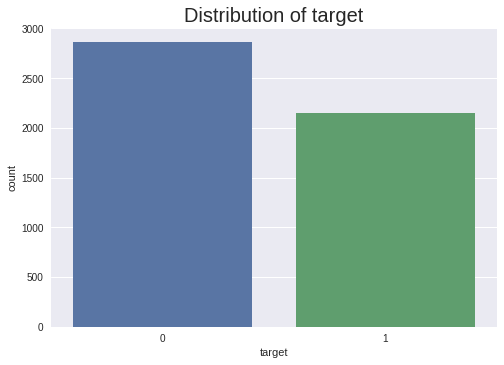

In [ ]:
# Visualisation de la distribution de la cible 
plt.style.use('seaborn')
sns.countplot(df_train['target'])
plt.title('Distribution of target', fontsize=20)

In [ ]:
df_train['keyword'].value_counts()[0:20]

collision           36
whirlwind           33
fatalities          32
armageddon          32
emergency%20plan    31
outbreak            31
sandstorm           31
flames              31
derailed            31
upheaval            30
desolation          30
earthquake          30
danger              30
inundated           30
harm                30
damage              30
deluge              29
flattened           29
flood               29
rainstorm           29
Name: keyword, dtype: int64

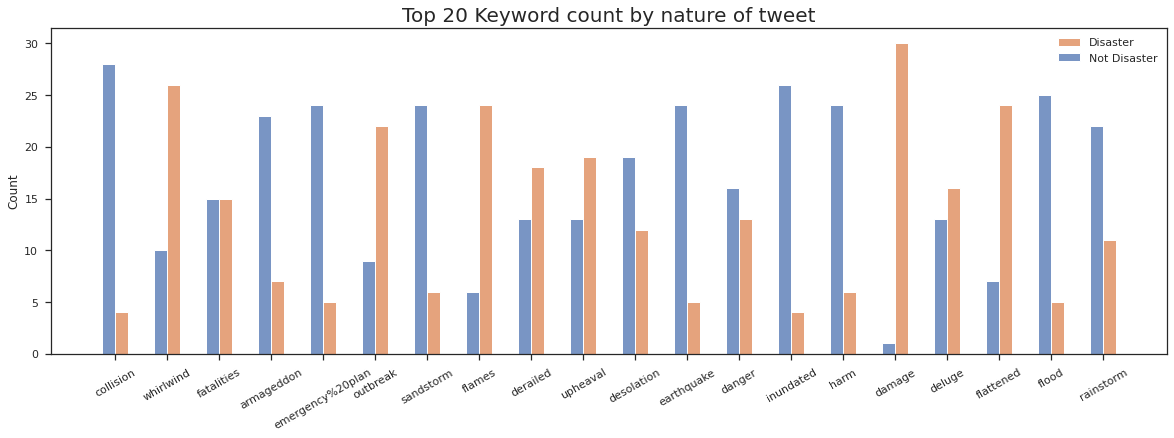

In [ ]:
# On va construire un histogramme des 20 mots clés les plus fréquents et on va comparer leur distribution selon la nature du tweet
#Let's take the 20 most frequent keywords
top20 = df_train['keyword'].value_counts()[0:20].index.tolist()
#We take all the keywords and targets if they are in the top20 list
df_top20 = [(keyword,target) for keyword,target in zip(df_train['keyword'], df_train['target']) if keyword in top20]
df_top20 = pd.DataFrame(df_top20, columns = ['keyword', 'target'])

#We plot the results to see the impact of keywords on target
sns.set_theme(style="ticks")
fig, ax = plt.subplots(1,1, figsize = (20,6))
g = sns.histplot(data = df_top20, x = 'keyword', hue = 'target', multiple = 'dodge', shrink = 0.5, ax = ax)
g.set_xticklabels(labels = top20, rotation=30)
g.set_xlabel('')
g.set_title('Top 20 Keyword count by nature of tweet', fontsize=20)
g.legend(['Disaster','Not Disaster'],loc="upper right")

plt.show()

In [ ]:
#Comme nous pouvons le voir, certains mots-clés sont plus fréquemment utilisés pour décrire les catastrophes que d'autres
#Jetons maintenant un coup d'œil à la colonne d'emplacement

In [ ]:
df_train['location'].value_counts()[0:20]

USA                104
New York            71
United States       50
London              45
Canada              29
Los Angeles, CA     26
UK                  26
Nigeria             23
Washington, DC      21
India               21
Kenya               20
Mumbai              20
Worldwide           19
Chicago, IL         18
Australia           18
California          17
Everywhere          15
New York, NY        15
California, USA     15
Florida             14
Name: location, dtype: int64

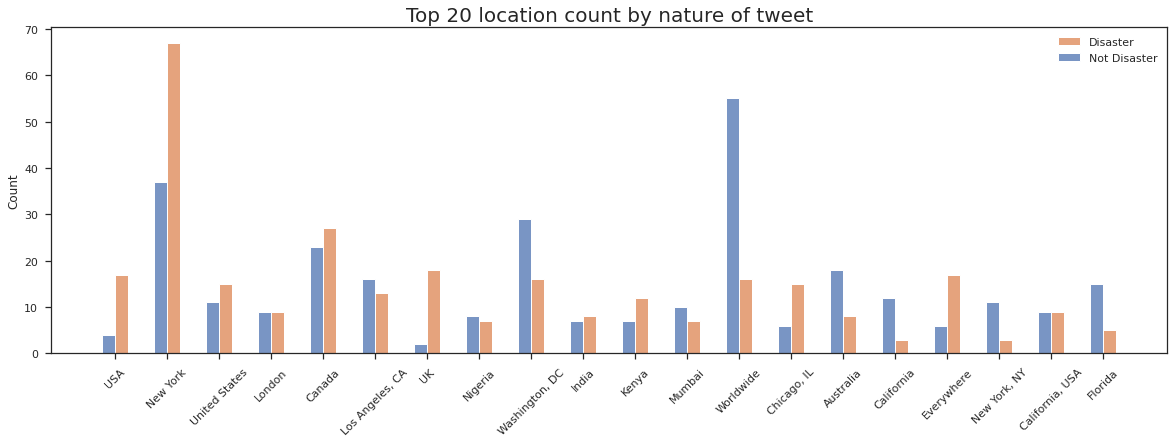

In [ ]:
#Prenons les 20 emplacements les plus fréquents et visualisons leur distribution selon la nature du tweet 
top20 = df_train['location'].value_counts()[0:20].index.tolist()
#We take all the locations and targets if they are in the top20 list
df_top20 = [(location,target) for location,target in zip(df_train['location'], df_train['target']) if location in top20]
df_top20 = pd.DataFrame(df_top20, columns = ['location', 'target'])

sns.set_theme(style="ticks")

fig,ax = plt.subplots(1,1, figsize = (20,6))

g20 = sns.histplot(data = df_top20, x = 'location', hue = 'target', multiple = 'dodge', shrink = 0.5, ax = ax)
g20.set_xticklabels(labels = top20, rotation=45)
g20.set_xlabel('')
g20.set_title('Top 20 location count by nature of tweet', fontsize=20)
g20.legend(['Disaster','Not Disaster'],loc="upper right")

plt.show()

In [ ]:
#L'emplacement n'est pas cohérent comme nous pouvons le voir par exemple "USA" et "United States" ou "California" et "California, USA",
#étant utilisés en même temps, nous devrons peut-être le nettoyer un peu si nous voulons l'utiliser.

II- Nettoyage de la colonne localisation 

In [ ]:
#On va sélectionner la localisation unique 
pd.DataFrame(df_train['location'].unique(), columns=['location']).sort_values(by='location')

,location
2999,
3314,Glasgow
928,"Melbourne, Australia"
1368,News
1800,å_
...,...
1981,å_: ?? ÌÑ ? : ?
3022,å_å_Los Mina Cityã¢
3082,å¡å¡Midwest Û¢Û¢
3156,åÊ(?Û¢`?Û¢å«)??


In [ ]:
# Comme on peut le voir ci-dessus il y a des mots mal orthographiés, l'utilisation d'abréviations et d'autres choses conduisant à des incohérences, essayons de nettoyer au mieux. 
#Je vais ensuite créer une fonction en utilisant regex

In [ ]:
   def correct_location(x):
    #special char
    x = re.sub(r"United States", "USA", x)
    x = re.sub(r"America", "USA", x)
    x = re.sub(r"America [|] New Zealand ", "USA", x)
    x = re.sub(r"Americas Newsroom", "USA", x)
    x = re.sub(r"us", "USA", x)
    x = re.sub(r"us-east-1a", "USA", x)

    x = re.sub(r"Los Angeles, CA", "Los Angeles", x)
    x = re.sub(r"Chicago, IL", "Chicago", x)

    x = re.sub(r"Boston MA", "Boston", x)
    x = re.sub(r"Boston [\]x89Û¢ Cape Cod [?]", "Boston", x)
    x = re.sub(r"Boston, MA", "Boston", x)
    x = re.sub(r"Boston, Massachusetts", "Boston", x)
    x = re.sub(r"Boston/Montreal ", "Boston", x)

    x = re.sub(r"Birmingham [&] Bristol", "Birmingham", x)
    x = re.sub(r"Birmingham UK", "Birmingham", x)
    x = re.sub(r"Birmingham and the Marches", "Birmingham", x)
    x = re.sub(r"Birmingham, England", "Birmingham", x)
    x = re.sub(r"Birmingham, UK ", "Birmingham", x)
    x = re.sub(r"Birmingham, United Kingdom", "Birmingham", x)

    x = re.sub(r"California, USA", "California", x)
    x = re.sub(r"California, United States", "California", x)
    x = re.sub(r"California or Colorado", "California", x)
    

    x = re.sub(r"New York, NY", "New York", x)
    x = re.sub(r"New York City", "New York", x)
    x = re.sub(r"New York, USA", "New York", x)
    x = re.sub(r"NY", "New York", x)
    x = re.sub(r"new york", "New York", x)
    x = re.sub(r"nc", "New York", x)
    x = re.sub(r"nyc", "New York", x)

    x = re.sub(r"Florida Forever", "Florida", x)
    x = re.sub(r"Florida USA", "Florida", x)
    x = re.sub(r"Florida but I wanna be n Texas", "Florida", x)
    x = re.sub(r"Florida, USA", "Florida", x)
    x = re.sub(r"Florida, USA", "Florida", x)

    x = re.sub(r"Dallas, TX", "Dallas", x)
    x = re.sub(r"Dallas, TX ", "Dallas", x)
    x = re.sub(r"Dallas, Tejas", "Dallas", x)
    x = re.sub(r"Dallas, Texas[.] ", "Dallas", x)

    x = re.sub(r"England ", "England", x)
    x = re.sub(r"England [&] Wales Border, UK", "England", x)
    x = re.sub(r"England, Great Britain[.]", "England", x)
    x = re.sub(r"England, United Kingdom", "England", x)
    x = re.sub(r"England,UK,Europe,Sol 3[.]", "England", x)
    x = re.sub(r"England[.]", "England", x)
    x = re.sub(r"English Midlands", "England", x)

    x = re.sub(r"Texas, USA", "Texas", x)
    x = re.sub(r"Lagos, Nigeria", "Nigeria", x)
    x = re.sub(r"Nxgerxa", "Lagos", x)

    x = re.sub(r"Tampa, FL", "Tampa", x)
    x = re.sub(r"Florida, USA", "Florida", x)
    x = re.sub(r"Asheville, NC", "Asheville", x)
    x = re.sub(r"Oklahoma City, OK ", "Oklahoma City", x)

    x = re.sub(r"Melbourne, Australia", "Australia", x)
    x = re.sub(r"Adelaide", "Australia", x)
    x = re.sub(r"Adelaide, Australia, Australia", "Australia", x)
    x = re.sub(r"Adelaide, South Australia", "Australia", x)
    x = re.sub(r"Australia ", "Australia", x)
    x = re.sub(r"Australian Capital Territory", "Australia", x)

    x = re.sub(r"Bangalore City, India", "Bangalore", x)
    x = re.sub(r"Bangalore, INDIA", "Bangalore", x)
    x = re.sub(r"Bangalore, India", "Bangalore", x)
    x = re.sub(r"Bangalore[.] India", "Bangalore", x)

    x = re.sub(r"Mumbai \(India\)", "Mumbai", x)
    x = re.sub(r"Mumbai india", "Mumbai", x)
    x = re.sub(r"Bangalore[.] India", "Mumbai", x)
    x = re.sub(r"Bangalore[.] India", "Mumbai", x)

    x = re.sub(r"Washington, DC", "Washington", x)
    x = re.sub(r"Washington, D[.]C[.]", "Washington", x)
    x = re.sub(r"Washington, D[.]C[.]", "Washington", x)
    x = re.sub(r"Washington [&] Charlotte", "Washington", x)
    x = re.sub(r"Washington 20009", "Washington", x)
    x = re.sub(r"Washington D[.]C[.]", "Washington", x)
    x = re.sub(r"Washington DC", "Washington", x)
    x = re.sub(r"Washington DC [/] Nantes", "Washington", x)
    x = re.sub(r"Washington NATIVE", "Washington", x)
    x = re.sub(r"Washington State", "Washington", x)
    x = re.sub(r"Washington state", "Washington", x)

    x = re.sub(r"San Francisco, CA", "San Francisco", x)

    x = re.sub(r"London, UK", "London", x)
    x = re.sub(r"London, England", "London", x)
    x = re.sub(r"London / Berlin / Online", "London", x)
    x = re.sub(r"London UK", "London", x)
    x = re.sub(r"London[.]", "London", x)
    x = re.sub(r"London/Bristol/Guildford", "London", x)
    x = re.sub(r"London/Lagos/FL ÌÏT: 6[.]6200132", "London", x)
    x = re.sub(r"London/New York", "London", x)
    x = re.sub(r"London/Outlaw Country", "London", x)
    x = re.sub(r"London/Surrey", "London", x)

    x = re.sub(r"Atlanta, GA", "Atlanta", x)
    x = re.sub(r"Atlanta [-] FAU class of '18", "Atlanta", x)
    x = re.sub(r"Atlanta Georgia", "Atlanta", x)
    x = re.sub(r"Atlanta Georgia ", "Atlanta", x)
    x = re.sub(r"Atlanta g[.]a[.]", "Atlanta", x)
    x = re.sub(r"Atlanta[(]ish[)], GA", "Atlanta", x)
    x = re.sub(r"Atlanta, Ga", "Atlanta", x)
    x = re.sub(r"Atlanta, Georgia", "Atlanta", x)
    x = re.sub(r"Atlanta, Georgia USA", "Atlanta", x)
    x = re.sub(r"Atlanta,Ga", "Atlanta", x)
    x = re.sub(r"Atlanta ", "Atlanta", x)
    x = re.sub(r"Atlanta USA", "Atlanta", x)
    x = re.sub(r"Atlanta[(]ish[)]", "Atlanta", x)
    x = re.sub(r"Atlanta,Ga", "Atlanta", x)

    x = re.sub(r"Sacramento, CA", "Sacramento", x)

    x = re.sub(r"Nashville, TN", "Nashville", x)
    x = re.sub(r"Denver, Colorado", "Denver", x)
    x = re.sub(r"Dallas, TX", "Dallas", x)
    x = re.sub(r"Houston, TX", "Houston", x)
    x = re.sub(r"Seattle, WA", "Seattle", x)
    x = re.sub(r"Pennsylvania, USA, WA", "Pennsylvania", x)
    x = re.sub(r"Memphis, TN", "Memphis", x)
    x = re.sub(r"Austin, TX", "Austin", x)
    x = re.sub(r"Austin TX", "Austin", x)
    x = re.sub(r"Austin [|] San Diego", "Austin", x)
    x = re.sub(r"Austin/Los Angeles", "Austin", x)

    x = re.sub(r"Portland, OR", "Portland", x)

    x = re.sub(r"Charlotte, NC", "Charlotte", x)
    x = re.sub(r"Charlotte ", "Charlotte", x)
    x = re.sub(r"Charlotte County Florida", "Charlotte", x)
    x = re.sub(r"Charlotte, N[.]C[.]", "Charlotte", x)
    x = re.sub(r"Charlotte, NC [|] KÌ¦ln, NRW", "Charlotte", x)
    x = re.sub(r"Charlotte, North Carolina", "Charlotte", x)
    x = re.sub(r"CharlotteCounty Florida", "Charlotte", x)
    x = re.sub(r"CharlotteNC", "Charlotte", x)
    x = re.sub(r"Charlottetown", "Charlotte", x)
    x = re.sub(r"Charlotte[|]Charlotte", "Charlotte", x)

    x = re.sub(r"Brooklyn, NY", "Brooklyn", x)

    x = re.sub(r"Brasil, Fortaleza ce", "Brazil", x)
    x = re.sub(r"Brasil,SP", "Brazil", x)
    x = re.sub(r"BrasÌ_lia", "Brazil", x)
    x = re.sub(r"Brazil", "Brazil", x)
    x = re.sub(r"Brazil ", "Brazil", x)

    x = re.sub(r"Calgary, Alberta", "Calgary", x)
    x = re.sub(r"Calgary, AB", "Calgary", x)
    x = re.sub(r"Calgary, AB, Canada", "Calgary", x)
    x = re.sub(r"Calgary/Airdrie/RedDeer/AB", "Calgary", x)
    x = re.sub(r"Calgary,AB, Canada", "Calgary", x)
    x = re.sub(r"Calgary, Canada", "Calgary", x)
    x = re.sub(r"Calgary, Alberta, Canada", "Calgary", x)
    x = re.sub(r"MontrÌ©al", "Montreal", x)
   
    x = re.sub(r"Alberta ", "Alberta", x)
    x = re.sub(r"Alberta Pack", "Alberta", x)
    x = re.sub(r"Alberta Pack", "Alberta", x)
    x = re.sub(r"Alberta [|] Sask[.] [|] Montana", "Alberta", x)

    x = re.sub(r"Morioh, Japan", "Japan", x)
    x = re.sub(r"Orlando, FL ", "Orlando", x)
    x = re.sub(r"Portland, OR", "Portland", x)
   
    x = re.sub(r"Afghanistan, USA", "Afghanistan", x)
    x = re.sub(r"Abuja", "Abuja", x)
    x = re.sub(r"Abuja,Nigeria", "Abuja", x)
    x = re.sub(r"Abuja", "Nigeria", x)

    x = re.sub(r"Alabama, USA", "Alabama", x)
    x = re.sub(r"Alameda and Pleasanton, CA", "Alameda", x)
    x = re.sub(r"Alameda, CA", "Alameda", x)

    x = re.sub(r"Alaska, USA", "Alaska", x)

    x = re.sub(r"Albuquerque New Mexico", "Albuquerque", x)

    x = re.sub(r"Alexandria, VA", "Alexandria", x)
    x = re.sub(r"Alexandria, VA, USA", "Alexandria", x)

    x = re.sub(r"All around the world", "worldwide!", x)
    x = re.sub(r"All around the world", "worldwide!", x)
    x = re.sub(r"All around the world baby", "worldwide!", x)
    x = re.sub(r"All around the world[!]", "worldwide!", x)
    x = re.sub(r"All Around the World baby", "worldwide!", x)
    x = re.sub(r"All Around the World[!]", "worldwide!", x)

    x = re.sub(r"Alicante, Spain", "Alicante", x)
    x = re.sub(r"Alicante, Valencia", "Alicante", x)

    return x

In [ ]:
#Nous effectuerons simultanément les changements sur le train et sur le test pour faciliter les prochaines parties de l'étude:
#on train
df_train['location_clean']=df_train['location'].apply(lambda x: correct_location(x))
print(df_train['location_clean'].tail(25))

#on test
df_test['location_clean'] = df_test['location'].apply(lambda x: correct_location(x))

7418                New Delhi,India
7419                   Xi'an, China
7420                         Mumbai
7421             Brooklyn, New York
7422           Robin Hood's County 
7424                            USA
7425                   Pennsylvania
7429                 Santa Cruz, CA
7432               Milwaukee County
7433    Click the link below, okay 
7435              probably not home
7438                              6
7443                            USA
7444                   At your back
7446                 Livingston, MT
7447                     California
7448                       Glasgow 
7449            Manhattan, New York
7450                  Denton, Texas
7451                         Global
7452                             TN
7454         #NewcastleuponTyne #UK
7456        VaNew Yorkouver, Canada
7457                        London 
7458                  LiNew Yorkoln
Name: location_clean, dtype: object


In [ ]:
#on train
#Il y a certaines villes qui s'écrivent ainsi : "New York City, US" on sépare avant et après la virgule et on ne garde que la première partie "New york City"
df_train['location_clean']=df_train['location_clean'].apply(lambda x: x.split(',')[0])
#Idem avec le point
df_train['location_clean']=df_train['location_clean'].apply(lambda x: x.split('.')[0])
#On supprime les espaces au début et à la fin 
df_train['location_clean']=df_train['location_clean'].apply(lambda x: x.strip())
#Nous mettons tout en minuscules car nous avons trouvé des doublons en minuscules
df_train['location_clean']=df_train['location_clean'].str.lower()
#Nous ne gardons que les lettres, tous les caractères non alpha sont supprimés, y compris les chiffres
df_train['location_clean']=df_train['location_clean'].apply(lambda x: "".join(ch for ch in x if ch.isalpha() or ch == ' '))
print(df_train['location_clean'].tail(25))

#on test
df_test['location_clean'] = df_test['location_clean'].apply(lambda x: x.split(',')[0])
df_test['location_clean'] = df_test['location_clean'].apply(lambda x: x.split('.')[0])
df_test['location_clean'] = df_test['location_clean'].apply(lambda x: x.strip())
df_test['location_clean'] = df_test['location_clean'].str.lower()
df_test['location_clean'] = df_test['location_clean'].apply(lambda x: "".join(ch for ch in x if ch.isalpha() or ch == ' '))

7418               new delhi
7419                    xian
7420                  mumbai
7421                brooklyn
7422      robin hoods county
7424                     usa
7425            pennsylvania
7429              santa cruz
7432        milwaukee county
7433    click the link below
7435       probably not home
7438                        
7443                     usa
7444            at your back
7446              livingston
7447              california
7448                 glasgow
7449               manhattan
7450                  denton
7451                  global
7452                      tn
7454    newcastleupontyne uk
7456         vanew yorkouver
7457                  london
7458           linew yorkoln
Name: location_clean, dtype: object


In [ ]:
df_train['location_clean'].value_counts()[0:20]

usa                    164
new york               126
london                  85
                        83
washington              56
los angeles             51
california              43
nigeria                 40
chicago                 37
canada                  35
worldwide               33
uk                      31
mumbai                  30
atlanta                 29
san franew yorkisco     26
india                   25
calgary                 23
seattle                 23
florida                 22
toronto                 22
Name: location_clean, dtype: int64

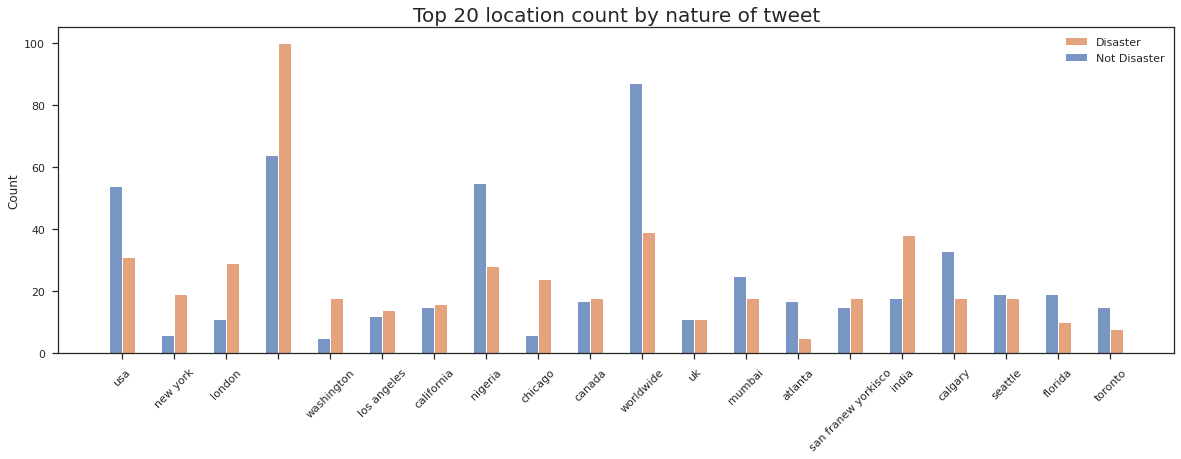

In [ ]:
#Visualisons à nouveau les données
#Prenons les 20 emplacements les plus fréquents
top20 = df_train['location_clean'].value_counts()[0:20].index.tolist()
#We take all the locations and targets if they are in the top20 list
df_top20 = [(location_clean,target) for location_clean,target in zip(df_train['location_clean'], df_train['target']) if location_clean in top20]
df_top20 = pd.DataFrame(df_top20, columns = ['location_clean', 'target'])

sns.set_theme(style="ticks")

fig,ax = plt.subplots(1,1, figsize = (20,6))

g20 = sns.histplot(data = df_top20, x = 'location_clean', hue = 'target', multiple = 'dodge', shrink = 0.5, ax = ax)
g20.set_xticklabels(labels = top20, rotation=45)
g20.set_xlabel('')
g20.set_title('Top 20 location count by nature of tweet', fontsize=20)
g20.legend(['Disaster','Not Disaster'],loc="upper right")

plt.show()

In [ ]:
#Comme on peut le voir les données sont plus propres, mais nous devons nous débarrasser des "non localisés" car il y en a trop,
#cela va biaiser les données.

In [ ]:
#On va supprimer les emplacements "non localisés"
#on train 

df_train['location_clean'] = df_train['location_clean'].apply(lambda x: '' if  x =="unlocated" else x)
df_train['location_clean']=df_train['location_clean'].replace('', np.nan)
df_train=df_train.dropna(subset=['location_clean'])


#on test

df_test['location_clean'] = df_test['location_clean'].apply(lambda x: '' if  x =="unlocated" else x)
df_test['location_clean']=df_test['location_clean'].replace('', np.nan)
df_test=df_test.dropna(subset=['location_clean'])

In [ ]:
df_train.shape

(4930, 5)

III- Nettoyage du texte

In [ ]:
import spacy
spacy.__version__
!python -m spacy download en_core_web_md -q
# Grêce à spacy on va supprimer les stop word, on remplace les tokens par des lemmas 

     |████████████████████████████████| 96.4 MB 1.4 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
# Import English using en_core_web_md.load()
import en_core_web_md
nlp = en_core_web_md.load()
# cet objet nlp on va l'utiliser sur des chaines de caractères de façon à extraire les tokens de nos chaines de caractères 

In [ ]:
# Import Stop words 
from spacy.lang.en.stop_words import STOP_WORDS
# on va importer les stop_words afin de les supprimer par la suite on va pas en avoir besoin pour faire une classification 

In [ ]:
#Outre la ponctuation, il existe  des abréviations. Nous allons commencer par créer un dictionnaire de recherche avec des abréviations
#courantes de phrases Twitter. Les termes de Tweet qui correspondent aux clés du dictionnaire seront remplacés par leur forme non abrégée.
lookup_dict = {
  'abt' : 'about',
  'afaik' : 'as far as i know',
  'bc' : 'because',
  'bfn' : 'bye for now',
  'bgd' : 'background',
  'bh' : 'blockhead',
  'br' : 'best regards',
  'btw' : 'by the way',
  'cc': 'carbon copy',
  'chk' : 'check',
  'dam' : 'do not annoy me',
  'dd' : 'dear daughter',
  'df': 'dear fiance',
  'ds' : 'dear son',
  'dyk' : 'did you know',
  'em': 'email',
  'ema' : 'email address',
  'ftf' : 'face to face',
  'fb' : 'facebook',
  'ff' : 'follow friday', 
  'fotd' : 'find of the day',
  'ftw': 'for the win',
  'fwiw' : 'for what it is worth',
  'gts' : 'guess the song',
  'hagn' : 'have a good night',
  'hand' : 'have a nice day',
  'hotd' : 'headline of the day',
  'ht' : 'heard through',
  'hth' : 'hope that helps',
  'ic' : 'i see',
  'icymi' : 'in case you missed it',
  'idk' : 'i do not know',
  'ig': 'instagram',
  'iirc' : 'if i remember correctly',
  'imho' : 'in my humble opinion',
  'imo' : 'in my opinion',
  'irl' : 'in real life',
  'iwsn' : 'i want sex now',
  'jk' : 'just kidding',
  'jsyk' : 'just so you know',
  'jv' : 'joint venture',
  'kk' : 'cool cool',
  'kyso' : 'knock your socks off',
  'lmao' : 'laugh my ass off',
  'lmk' : 'let me know', 
  'lo' : 'little one',
  'lol' : 'laugh out loud',
  'mm' : 'music monday',
  'mirl' : 'meet in real life',
  'mrjn' : 'marijuana',
  'nbd' : 'no big deal',
  'nct' : 'nobody cares though',
  'njoy' : 'enjoy',
  'nsfw' : 'not safe for work',
  'nts' : 'note to self',
  'oh' : 'overheard',
  'omg': 'oh my god',
  'oomf' : 'one of my friends',
  'orly' : 'oh really',
  'plmk' : 'please let me know',
  'pnp' : 'party and play', 
  'qotd' : 'quote of the day',
  're' : 'in reply to in regards to',
  'rtq' : 'read the question',
  'rt' : 'retweet',
  'sfw' : 'safe for work',
  'smdh' : 'shaking my damn head', 
  'smh' : 'shaking my head',
  'so' : 'significant other',
  'srs' : 'serious',
  'tftf' : 'thanks for the follow',
  'tftt' : 'thanks for this tweet',
  'tj' : 'tweetjack',
  'tl' : 'timeline',
  'tldr' : 'too long did not read',
  'tmb' : 'tweet me back',
  'tt' : 'trending topic',
  'ty' : 'thank you',
  'tyia' : 'thank you in advance',
  'tyt' : 'take your time',
  'tyvw' : 'thank you very much',
  'w': 'with', 
  'wtv' : 'whatever',
  'ygtr' : 'you got that right',
  'ykwim' : 'you know what i mean',
  'ykyat' : 'you know you are addicted to',
  'ymmv' : 'your mileage may vary',
  'yolo' : 'you only live once',
  'yoyo' : 'you are on your own',
  'yt': 'youtube',
  'yw' : 'you are welcome',
  'zomg' : 'oh my god to the maximum'
}


In [ ]:
#On créée une fonction qui nous permet de transformer les phrases abrégées en phrases non abrégées
def abbrev_conversion(text):
    words = text.split() 
    abbrevs_removed = [] 
    
    for i in words:
        if i in lookup_dict:
            i = lookup_dict[i]
        abbrevs_removed.append(i)
            
    return ' '.join(abbrevs_removed)
#Le texte c'est la critique 

In [ ]:
 abbrev_conversion('zomg')

'oh my god to the maximum'

In [ ]:
#on train 
#pour supprimer les urls 
df_train["text_clean"] = df_train["text"].apply(lambda x: re.sub(re.compile(r'(?:\@|http?\://|https?\://|www)\S+'), '', x) if pd.isna(x) != True else x) 
#On supprimer tous les caractères non alphanumériques à l'exception des espaces 
df_train["text_clean"] = df_train["text_clean"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
#On va transformer ttes les phrases abrégées en non abrgées mais on ne prend pas en compte les NAN.
df_train["text_clean"]= df_train["text_clean"].apply(lambda x: abbrev_conversion(x) if pd.isna(x) != True else x)
#On supprime les doubles espaces et les espaces au début et à la fin des chaînes et on transforme en miniscule
df_train["text_clean"] =df_train["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
#On supprime les mots vides et remplace chaque mot par son lemme
#pour chaque token ds nlp appliqué à x qui représente un élément dans ma colonne on va chercher les lemmas mais
#uniquement si le texte associé à mon token n'est pas ds les stop_words et que le lemma associé à mon token n'est pas dans les stop_words non plus
df_train["text_clean"]= df_train["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))
print(df_train.head())

#on test
df_test["text_clean"] = df_test["text"].apply(lambda x: re.sub(re.compile(r'(?:\@|http?\://|https?\://|www)\S+'), '', x) if pd.isna(x) != True else x)  
df_test["text_clean"] = df_test["text_clean"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
df_test["text_clean"]= df_test["text_clean"].apply(lambda x: abbrev_conversion(x) if pd.isna(x) != True else x)
df_test["text_clean"] =df_test["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
df_test["text_clean"]= df_test["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

   keyword  ...                                         text_clean
31  ablaze  ...                            wholesale market ablaze
32  ablaze  ...                           try bring heavy metal rt
33  ablaze  ...  africanbaze break newsnigeria flag set ablaze aba
34  ablaze  ...                                     cry set ablaze
35  ablaze  ...                         plus look sky night ablaze

[5 rows x 6 columns]


In [ ]:
df_train.shape

(4930, 6)

Le modèle prédit si un tweet donné parle d'un véritable désastre ou non. Si oui, il prédit un 1. Sinon, il prédit un 0.

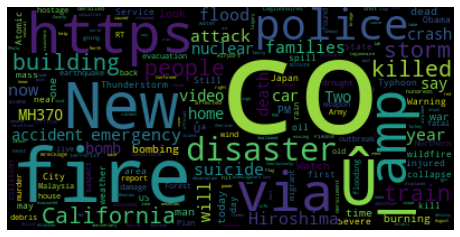

In [ ]:
# Word cloud of text in disaster and non-disaster tweets

# Cleaned dataframe of disaster
df_true = df_train[df_train.target == 1]

text_true = " ".join(txt for txt in df_true['text'])

text_cloud = WordCloud(collocations=False, background_color='black').generate(text_true)
plt.axis("off")
plt.imshow(text_cloud, interpolation='bilinear')

In [ ]:
#Words in disaster tweets:- disaster, new, fire, via, year, suicide, police, home,killed, crash, storm, etc.

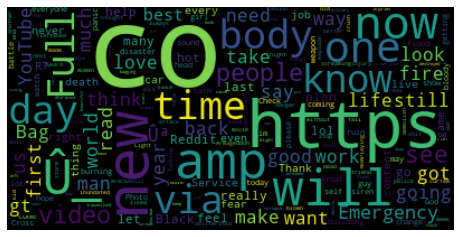

In [ ]:
# Cleaned dataframe of disaster
df_true = df_train[df_train.target == 0]

text_true = " ".join(txt for txt in df_true['text'])

text_cloud = WordCloud(collocations=False, background_color='black').generate(text_true)
plt.axis("off")
plt.imshow(text_cloud, interpolation='bilinear')

In [ ]:
#Words in non-disaster tweets:- new, love, one, time, now, body, people,good, etc.

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=None) # instanciate the tokenizer 
tokenizer.fit_on_texts(df_train.text_clean)#il va créer son tableau de correspondance pour remplacer les textes en liste d'indices 
df_train["text_encoded"] = tokenizer.texts_to_sequences(df_train.text_clean)# pour remplacer le texte en liste d'indices 

df_train["len_text"] = df_train["text_encoded"].apply(lambda x: len(x))
df_train= df_train[df_train["len_text"]!=0] 
df_train 

,keyword,location,text,target,location_clean,text_clean,text_encoded,len_text
31,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,birmingham,wholesale market ablaze,"[1676, 216, 368]",3
32,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,est,try bring heavy metal rt,"[100, 257, 481, 808, 59]",5
33,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,africa,africanbaze break newsnigeria flag set ablaze aba,"[4024, 93, 4025, 336, 98, 368, 740]",7
34,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,philadelphia,cry set ablaze,"[809, 98, 368]",3
35,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,london,plus look sky night ablaze,"[1415, 17, 587, 181, 368]",5
...,...,...,...,...,...,...,...,...
7452,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0,tn,bright wreck,"[2853, 76]",2
7454,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0,newcastleupontyne uk,s relax think wife wreck cake goner mind laugh...,"[5, 2258, 30, 1226, 76, 538, 10466, 843, 113, ...",11
7456,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0,vanew yorkouver,day work pretty wreck hahaha shoutout family,"[14, 34, 573, 76, 3983, 10468, 22]",7
7457,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0,london,fx forex trading cramer igers 3 word wreck dis...,"[10469, 10470, 10471, 2052, 2051, 58, 324, 76,...",10


In [ ]:
#On fait de même sur le set de test, sauf qu'on ne fit pas sur le tokenizer 
df_test["text_encoded"] = tokenizer.texts_to_sequences(df_test.text_clean)
df_test["len_text"] =df_test["text_encoded"].apply(lambda x: len(x))
df_test=df_test[df_test["len_text"]!=0] 

In [ ]:
# on rajoute du padding pour avoir la même longueur dans tte les phrase 
train_pad = tf.keras.preprocessing.sequence.pad_sequences(df_train.text_encoded, padding="post")
test_pad = tf.keras.preprocessing.sequence.pad_sequences(df_test.text_encoded, padding="post")
train_pad

array([[ 1676,   216,   368, ...,     0,     0,     0],
       [  100,   257,   481, ...,     0,     0,     0],
       [ 4024,    93,  4025, ...,     0,     0,     0],
       ...,
       [   14,    34,   573, ...,     0,     0,     0],
       [10469, 10470, 10471, ...,     0,     0,     0],
       [  122,  3252,   671, ...,     0,     0,     0]], dtype=int32)

In [ ]:
test_pad.shape

(2110, 20)

In [ ]:
# on transforme notre dataset en jeu de données tensoriel dans lequel on va mettre un tuple (1er élément nos données, 2ème élément notre vble cible ) 

train_ds = tf.data.Dataset.from_tensor_slices((train_pad, df_train["target"].values))
train_ds
# On doit faire cette transformation parce que qd on entraine le modèle les layers ne prennent que des tenseurs 

<TensorSliceDataset shapes: ((25,), ()), types: (tf.int32, tf.int64)>

In [ ]:
df_train.shape[0]

4893

In [ ]:
#Je split mon dataset en 80 % d'échantillon de train et 20% d'échantillon de val

TAKE_SIZE = int(0.8*df_train.shape[0])

train_data = train_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(32)

val_data = train_ds.skip(TAKE_SIZE)
val_data = val_data.batch(32)

# on applique le shuffle pr qu'à la fin de chaque époque les données se remélangent et on les organisent par
# batch de 32 phrases 

In [ ]:
#On visualise la forme de notre batch 
for text, target in train_data.take(1):
  print(text, target)
# ça me sort deux aobjets un batch d'input et un batch de targuet shape (32,17) 32 c'est le batch et 17 la longueur de la séquence, 
# notre targuet a une shape de 32 

tf.Tensor(
[[3237  380   51  101  322 5742  433  199    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [ 120    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [ 234  297  645  124 4223 1728  283 2697 1243  489 1443 4224 4225    0
     0    0    0    0    0    0    0    0    0    0    0]
 [3890  126  671 1164  480  628 1164 9090   18  668  863 2611 1112 9091
     0    0    0    0    0    0    0    0    0    0    0]
 [1879   53  934  240 2463   38 8331  781 8332    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [ 210 1535  210 5868  125 2178  572 1913 2369 1803 1879   39    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1   83  185  152   80    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [ 641 1457  907  316 1106  407 1458 1742    0    0    0    0    0    0
     0 

IV-**Modeling**

In [ ]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM,GlobalAveragePooling1D, Dropout

In [ ]:
vocab_size=len(tokenizer.word_index)
vocab_size

10471

**1- Embedding**

In [ ]:
# c'est le nbre de mots qu'on a séléctionné dans notre tokenizer 
model_embedding = tf.keras.Sequential([
                  # Couche d'Input Word Embedding(chaque indice va être représenté par un vecteur pour avoir une représentation plus riche qui nous donnera la possibilité d'analyser plus finement les mots de nos textes)         
                  tf.keras.layers.Embedding(input_dim=vocab_size+1,output_dim=64, input_shape=[text.shape[1]],name="embedding"), # chaque mot va être représeenté par un vecteur de 8 valeurs
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),# pr supprimer la dimension séquentielle, il va résumer l'information

                  # Couche Dense classique
                  tf.keras.layers.Dense(32, activation='relu'),
                  tf.keras.layers.Dense(16, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="sigmoid") # c'est la couche de prédiction avec une classification binaire 
])
# input_dim c'est le nbre de mots utilisés , output_dim c'est le vecteur auquel je vais représenter chacun de mes mots 
#et input shape c'est la longueur de mes phrases

In [ ]:
vocab_size+1

10472

In [ ]:
text.shape[1]

25

In [ ]:
model_embedding.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 64)            670208    
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 672,833
Trainable params: 672,833
Non-trainable params: 0
________________________________________________

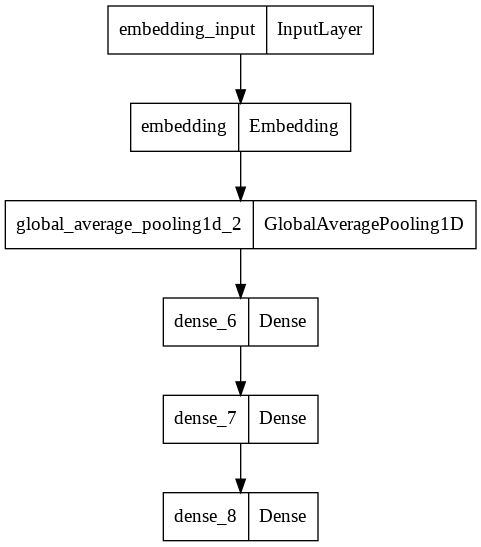

In [ ]:
tf.keras.utils.plot_model(
    model_embedding, show_shapes=False, show_layer_names=True
)

In [ ]:
model_embedding.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()]
              )
# Vu qu'on est en classification binaire notre fonction coût est Binary Crossentropy le modèle va s'entainer par la descente de gradient 
# et optimiser les paralètres, il y a plusieurs manière algorithmique d'implémenter la descente de gradient on va choisir l'optomizer Adam 
# il va adapter le gradient avec le learning rate, le learning rate de base par défaut est de 0.001, comme la binarycrossentropy n'est pas
# très interprétable on ajoute une metrics BinaryAccuracy qui est le pourcentage de pérdictions exacates

In [ ]:
# Entrainement du modèle 
history_embedding= model_embedding.fit(train_data,
                    validation_data=val_data,
                    epochs=20, 
                  )
# Qd la val loss augmente on arrête l'entrainement pr ne pas entrer ds le surapprentissage 

Epoch 1/20
123/123 [==============================] - 2s 11ms/step - loss: 0.6840 - binary_accuracy: 0.5680 - val_loss: 0.6811 - val_binary_accuracy: 0.5485
Epoch 2/20
123/123 [==============================] - 1s 10ms/step - loss: 0.6534 - binary_accuracy: 0.5973 - val_loss: 0.6424 - val_binary_accuracy: 0.6813
Epoch 3/20
123/123 [==============================] - 1s 10ms/step - loss: 0.5230 - binary_accuracy: 0.7961 - val_loss: 0.5238 - val_binary_accuracy: 0.7589
Epoch 4/20
123/123 [==============================] - 1s 10ms/step - loss: 0.3401 - binary_accuracy: 0.8740 - val_loss: 0.4738 - val_binary_accuracy: 0.7967
Epoch 5/20
123/123 [==============================] - 1s 10ms/step - loss: 0.2483 - binary_accuracy: 0.9070 - val_loss: 0.4862 - val_binary_accuracy: 0.7937
Epoch 6/20
123/123 [==============================] - 1s 10ms/step - loss: 0.1906 - binary_accuracy: 0.9282 - val_loss: 0.5243 - val_binary_accuracy: 0.7681
Epoch 7/20
123/123 [==============================] - 1s 1

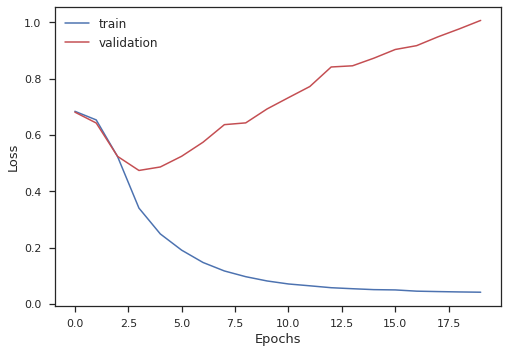

In [ ]:
import matplotlib.pyplot as plt
# Visualization of the training process on the loss function 
plt.plot(history_embedding.history["loss"], color="b", label='train')
plt.plot(history_embedding.history["val_loss"], color="r", label='validation')
plt.ylabel("Loss", fontsize = 13)
plt.xlabel("Epochs", fontsize = 13)
plt.legend(fontsize= 12)
plt.show()

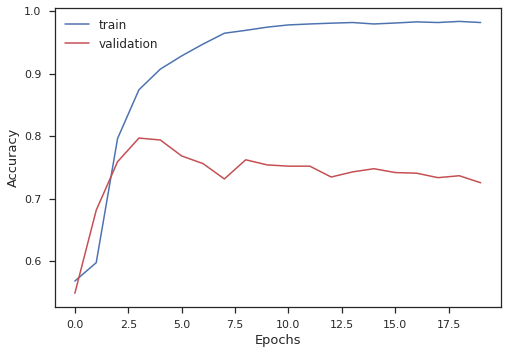

In [ ]:
# Visualization of accuracy training 
plt.plot(history_embedding.history["binary_accuracy"], color="b", label='train')
plt.plot(history_embedding.history["val_binary_accuracy"], color="r", label='validation')
plt.ylabel("Accuracy", fontsize = 13)
plt.xlabel("Epochs", fontsize = 13)
plt.legend(fontsize= 12)
plt.show()

In [ ]:
# On peut dire qu'il y a du surapprentissage la loss de train diminue alors que la loss de val augemente 

**2-Simple RNN**

In [ ]:
model_srnn = tf.keras.Sequential([
                  # Word Embedding layer           
                  Embedding(input_dim=vocab_size+1,output_dim=64, input_shape=[text.shape[1]],name="embedding"),
                  SimpleRNN(units=32, return_sequences=False), # returns the last output
                  # Dense layers once the data is flat
                  Dense(16, activation='relu'),
                  # output layer with as many neurons as the number of classes
                  # for the target variable and softmax activation
                  Dropout(0.5),
                  Dense(1, activation="sigmoid")
])
#le choix de la sigmoid parce que notre target va avoir deux valeurs 0 ou 1 s'il y a catastrophe 
# vocab_size c'est le nbre de mot dont on dispose +1 pr le padding 
# input_shape : le nombre de paramètre 

In [ ]:
model_srnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 64)            670208    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                3104      
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 17        
                                                                 
Total params: 673,857
Trainable params: 673,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_srnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), # c'est l'algorithme de descente de gradient spécifique qu'on veut choisir pr l'entraîner
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
# Entrainement du modèle 
history_srnn= model_srnn.fit(train_data,
                    validation_data=val_data,
                    epochs=20, 
                  )

Epoch 1/20
123/123 [==============================] - 3s 17ms/step - loss: 0.6743 - binary_accuracy: 0.5838 - val_loss: 0.6499 - val_binary_accuracy: 0.6251
Epoch 2/20
123/123 [==============================] - 2s 19ms/step - loss: 0.4838 - binary_accuracy: 0.8025 - val_loss: 0.6170 - val_binary_accuracy: 0.6844
Epoch 3/20
123/123 [==============================] - 3s 24ms/step - loss: 0.2357 - binary_accuracy: 0.9323 - val_loss: 0.6980 - val_binary_accuracy: 0.6874
Epoch 4/20
123/123 [==============================] - 2s 16ms/step - loss: 0.1308 - binary_accuracy: 0.9653 - val_loss: 0.8737 - val_binary_accuracy: 0.6650
Epoch 5/20
123/123 [==============================] - 2s 16ms/step - loss: 0.0960 - binary_accuracy: 0.9722 - val_loss: 0.9895 - val_binary_accuracy: 0.6711
Epoch 6/20
123/123 [==============================] - 2s 16ms/step - loss: 0.0726 - binary_accuracy: 0.9752 - val_loss: 1.1156 - val_binary_accuracy: 0.6364
Epoch 7/20
123/123 [==============================] - 2s 1

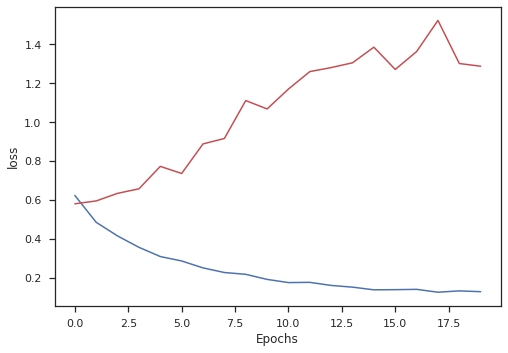

In [ ]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history_srnn.history["loss"], color="b", label='train')
plt.plot(history_srnn.history["val_loss"], color="r", label='validation')
plt.ylabel("Loss", fontsize = 13)
plt.xlabel("Epochs", fontsize = 13)
plt.legend(fontsize= 12)
plt.show()
# comme le schéma le montre on commence à overfitter depuis le début la val loss n'arrête pas d'augmenter 

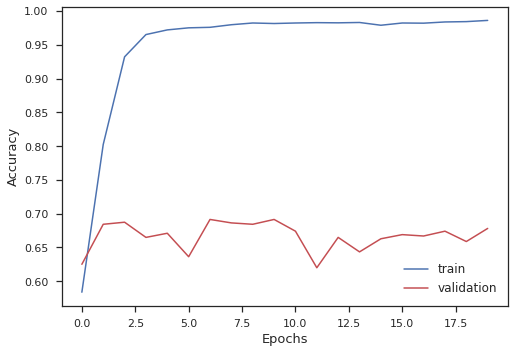

In [ ]:
# Visualization of accuracy training 
plt.plot(history_srnn.history["binary_accuracy"], color="b", label='train')
plt.plot(history_srnn.history["val_binary_accuracy"], color="r", label='validation')
plt.ylabel("Accuracy", fontsize = 13)
plt.xlabel("Epochs", fontsize = 13)
plt.legend(fontsize= 12)
plt.show()

In [ ]:
# L'inconvenient du SRNN c'est qu'il n'est pas efficace sur les phrases longues


In [ ]:
model_srnn.save("model_simpleRNN.h5")

**3-GRU**

In [ ]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM
model_gru = tf.keras.Sequential([
                  Embedding(input_dim=vocab_size+1,output_dim=64, input_shape=[text.shape[1]],name="embedding"),
                  #GRU(units=32, return_sequences=True), # maintains the sequential nature
                  tf.keras.layers.Bidirectional(GRU(units=16, return_sequences=False)), # returns the last output
                  #Dense(16, activation='relu'),
                  Dropout(0.5),
                  Dense(1, activation="sigmoid")

])

In [ ]:
model_gru.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 64)            670208    
                                                                 
 bidirectional_22 (Bidirecti  (None, 32)               7872      
 onal)                                                           
                                                                 
 dropout_23 (Dropout)        (None, 32)                0         
                                                                 
 dense_48 (Dense)            (None, 1)                 33        
                                                                 
Total params: 678,113
Trainable params: 678,113
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_gru.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
# Entrainement du modèle 
history_gru = model_gru.fit(train_data,
                    validation_data=val_data,
                    epochs=20, 
                  )

Epoch 1/20
123/123 [==============================] - 9s 38ms/step - loss: 0.6793 - binary_accuracy: 0.5715 - val_loss: 0.6756 - val_binary_accuracy: 0.5485
Epoch 2/20
123/123 [==============================] - 4s 31ms/step - loss: 0.5575 - binary_accuracy: 0.7213 - val_loss: 0.5131 - val_binary_accuracy: 0.7732
Epoch 3/20
123/123 [==============================] - 4s 31ms/step - loss: 0.3529 - binary_accuracy: 0.8776 - val_loss: 0.4876 - val_binary_accuracy: 0.7835
Epoch 4/20
123/123 [==============================] - 4s 31ms/step - loss: 0.2343 - binary_accuracy: 0.9236 - val_loss: 0.5176 - val_binary_accuracy: 0.7814
Epoch 5/20
123/123 [==============================] - 4s 31ms/step - loss: 0.1737 - binary_accuracy: 0.9497 - val_loss: 0.5764 - val_binary_accuracy: 0.7487
Epoch 6/20
123/123 [==============================] - 4s 31ms/step - loss: 0.1286 - binary_accuracy: 0.9637 - val_loss: 0.6173 - val_binary_accuracy: 0.7569
Epoch 7/20
123/123 [==============================] - 4s 3

On peut dire qu'il y a bcp de surapprentissage mais le score n'est pas mal donc le modèle est entrain d'apprendre quelque chose puisque
l'accuracy est supérieure à 70%, on peut dire qu'à peu près à 70% le modèle arrive à prédire si le tweets annonce un véritable désastre ou nn .

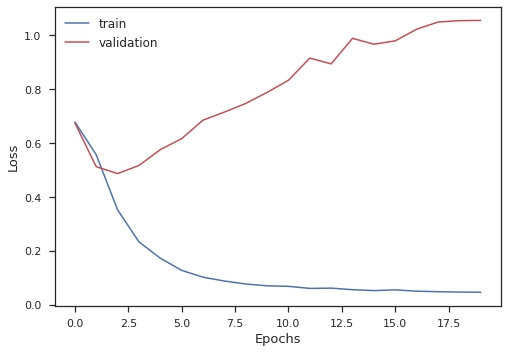

In [ ]:
# Visualization of the training process on the loss function 
plt.plot(history_gru.history["loss"], color="b", label='train')
plt.plot(history_gru.history["val_loss"], color="r", label='validation')
plt.ylabel("Loss", fontsize = 13)
plt.xlabel("Epochs", fontsize = 13)
plt.legend(fontsize= 12)
plt.show()

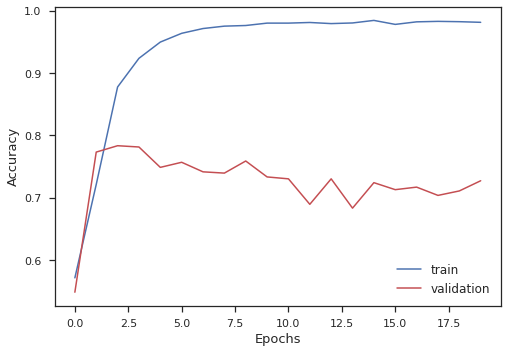

In [ ]:
# Visualization of accuracy training 
plt.plot(history_gru.history["binary_accuracy"], color="b", label='train')
plt.plot(history_gru.history["val_binary_accuracy"], color="r", label='validation')
plt.ylabel("Accuracy", fontsize = 13)
plt.xlabel("Epochs", fontsize = 13)
plt.legend(fontsize= 12)
plt.show()

In [ ]:
model_gru.save("model_gru.h5")

In [ ]:
model_lstm= tf.keras.Sequential([
                  Embedding(input_dim=vocab_size+1,output_dim=64, input_shape=[text.shape[1]],name="embedding"),
                  #LSTM(units=32, return_sequences=True), # maintains the sequential nature
                  tf.keras.layers.Bidirectional(LSTM(units=16, return_sequences=False)), # returns the last output
                  #Dense(16, activation='relu'),
                  Dropout(0.5),
                  Dense(1, activation="sigmoid")
])
# Bidirectional ça permet de dupliquer le nbre de neurones la moitié des neurones va lire la séquence de gauche
# à droite et l'autre moitié va la lire de droite à gauche  

In [ ]:
model_lstm.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 64)            670208    
                                                                 
 bidirectional_23 (Bidirecti  (None, 32)               10368     
 onal)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 32)                0         
                                                                 
 dense_49 (Dense)            (None, 1)                 33        
                                                                 
Total params: 680,609
Trainable params: 680,609
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
# Entrainement du modèle 
history_lstm = model_lstm.fit(train_data,
                    validation_data=val_data,
                    epochs=20, 
                  )

Epoch 1/20
123/123 [==============================] - 9s 37ms/step - loss: 0.6735 - binary_accuracy: 0.5669 - val_loss: 0.6630 - val_binary_accuracy: 0.5485
Epoch 2/20
123/123 [==============================] - 4s 31ms/step - loss: 0.5747 - binary_accuracy: 0.7105 - val_loss: 0.5472 - val_binary_accuracy: 0.7416
Epoch 3/20
123/123 [==============================] - 4s 30ms/step - loss: 0.3728 - binary_accuracy: 0.8618 - val_loss: 0.4856 - val_binary_accuracy: 0.7896
Epoch 4/20
123/123 [==============================] - 4s 29ms/step - loss: 0.2325 - binary_accuracy: 0.9205 - val_loss: 0.5612 - val_binary_accuracy: 0.7783
Epoch 5/20
123/123 [==============================] - 4s 29ms/step - loss: 0.1534 - binary_accuracy: 0.9543 - val_loss: 0.6666 - val_binary_accuracy: 0.7620
Epoch 6/20
123/123 [==============================] - 4s 29ms/step - loss: 0.1204 - binary_accuracy: 0.9691 - val_loss: 0.7433 - val_binary_accuracy: 0.7436
Epoch 7/20
123/123 [==============================] - 4s 2

On peut dire qu'il y a bcp de surapprentissage mais le score n'est pas mal donc le modèle est entrain d'apprendre puisque l'accuracy est à 74%, le modèle lstm donne des scores un peu mieux que GRU. 


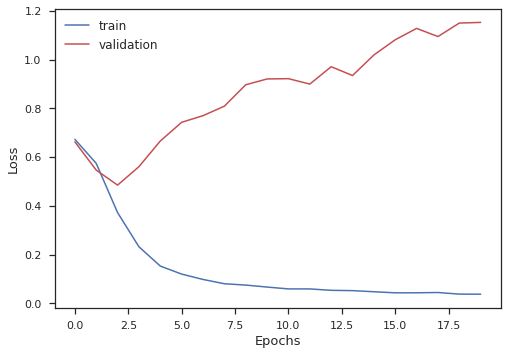

In [ ]:
# Visualization of the training process on the loss function 
plt.plot(history_lstm.history["loss"], color="b", label='train')
plt.plot(history_lstm.history["val_loss"], color="r", label='validation')
plt.ylabel("Loss", fontsize = 13)
plt.xlabel("Epochs", fontsize = 13)
plt.legend(fontsize= 12)
plt.show()

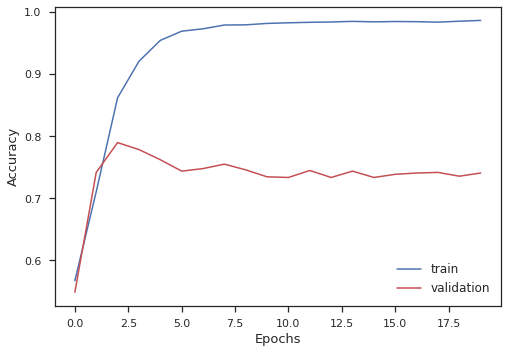

In [ ]:
# Visualization of accuracy training 
plt.plot(history_lstm.history["binary_accuracy"], color="b", label='train')
plt.plot(history_lstm.history["val_binary_accuracy"], color="r", label='validation')
plt.ylabel("Accuracy", fontsize = 13)
plt.xlabel("Epochs", fontsize = 13)
plt.legend(fontsize= 12)
plt.show()

In [ ]:
# Lstm ce sont des neurones qui sont capables d'utiliser à la fois de la mémoire de court terme et de la mémoire 
# de long terme on a deux mémoires une mémoire interne au neurone c'est cell state et une autre mémoire qui va 
# communiquer  avec les autres neurones et qui est le hidden state 

In [ ]:
model_lstm.save("model_lstm.h5")

In [ ]:
pred=model_lstm.predict(train_pad)
# je fais de la prédictions pour toutes mes séquences confondus train et val 
pred

array([[9.9522161e-01],
       [3.6330432e-02],
       [9.9829638e-01],
       ...,
       [5.8322251e-03],
       [2.9620528e-04],
       [2.2951365e-03]], dtype=float32)

In [ ]:
pred.squeeze()

array([9.9522161e-01, 3.6330432e-02, 9.9829638e-01, ..., 5.8322251e-03,
       2.9620528e-04, 2.2951365e-03], dtype=float32)

In [ ]:
target=df_train.target

In [ ]:
df_eval=pd.DataFrame({"pred":pred.squeeze(),"target":target,"text":df_train.text_clean})
df_eval

,pred,target,text
31,0.995222,1,wholesale market ablaze
32,0.036330,0,try bring heavy metal rt
33,0.998296,1,africanbaze break newsnigeria flag set ablaze aba
34,0.031449,0,cry set ablaze
35,0.008532,0,plus look sky night ablaze
...,...,...,...
7452,0.001370,0,bright wreck
7454,0.000206,0,s relax think wife wreck cake goner mind laugh...
7456,0.005832,0,day work pretty wreck hahaha shoutout family
7457,0.000296,0,fx forex trading cramer igers 3 word wreck dis...


In [ ]:
# On prédit si un tweet donné parle d'un véritable désastre ou non. Si oui on prédit un 1 sinon on prédit un 0.
# On peut dire que notre modèle fait de bonnes prédictions puisque pr cry set ablaze et plus look sky night ablaze 
# il déclare que ce sont de fausses déclarations 

In [ ]:
#prediction = model_lstm.predict(test_pad)

In [ ]:
submission = pd.read_csv("sample_submission.csv")
submission["target"] = prediction
submission["target"] = submission["target"].apply(lambda x : 0 if x < 0.5 else 1)
submission.head(5)